The goal of this notebook is to train to classify whether a Bashkir-Russian sentence pair is a correct translation. 

It tries the following configurations:
+ Just classifier training on the whole training data => cannot go above 80% of ROC AUC (or 56% recall @ rejecting n_bad)
+ **Training on the positive data only, with contrastive artificial negatives** 
    * **simple negatives (fully unrelated)** => AUC 75% / recall 55%. At 0.5 threshold, almost no false negatives, but only 1/3 recall. 
    * **hard negatives (distorted vs clean related)** => AUC 78% / recall 54%
    * harder negatives (reconstructed by a LM vs clean related, in the Notebook 9) => AUC 78% / recall 54% anyway. 
    * traning on a larger corpus (AigizK/bashkir-russian-parallel-corpora) => AUC 75% / recall 51%
- Training on the whole training data + MLM or TLM


Heavily inspired by https://github.com/slone-nlp/myv-nmt/blob/main/dirty-code-2022/model_training/02_pretrain_sentence_encoder.ipynb

In [1]:
import pandas as pd
import numpy as np

import torch
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [16]:
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
import random

In [3]:
from transformers.optimization import Adafactor
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

In [4]:
data = pd.read_csv('../data/joint-ba-ru.tsv', sep='\t')

data.data_split.value_counts()

train    104317
test      35648
dev       34998
val        1743
Name: data_split, dtype: int64

In [5]:
data_train = data[data.data_split=='train']
data_val = data[data.data_split=='val'].copy()
data_train.sample(3)

,date,ba,ru,is_correct,data_split
117513,07/01/2023 18:51:41,"Поллианна мине аңлар, тип уйлайым.","Думаю, Поллианна меня поймет.",1,train
58730,18/07/2022 20:14:34,— Мин...,— Я...,1,train
14830,03/10/2021 17:31:52,"Атайың мәрхүмдең ҡорҙаш дуҫы ине, шуның хаҡына...","Папа, желая направить беседу в другое русло, с...",1,train


# Loading the model

In [6]:
def get_pairs_batch(bs=4):
    batch = data_train.sample(bs)
    pp = [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [row.is_correct for row in batch.itertuples()]
    return [list(t) for t in zip(*pp)], labels

In [12]:
data_train_correct = data_train[data_train.is_correct == 1]
print(data_train_correct.shape, data_train.shape)

(81268, 5) (104317, 5)


In [14]:
all_pairs = [(row.ba, row.ru) for row in tqdm(data_train_correct.itertuples())]
len(all_pairs)

0it [00:00, ?it/s]

81268

In [17]:
random.sample(all_pairs, 2)

[('— Шунан, әле килешеп-фәлән бөттөләрме икән?',
  '— Уже договорились или как?'),
 ('Май башында Ырыҫмөхәммәт етәкселегендә ҡарағалпаҡтарҙың биш йөҙ кешелек ғәскәре килгәс, Алдар батыр бөтә әтрәттәре менән Сыбаркүлгә ҡарай походҡа ҡуҙғалды.',
  'В начале мая, по прибытии Рысмухамета с пятью сотнями всадников, Алдар-батыр направился к озеру Чебаркуль.')]

In [98]:
def get_pairs_contrastive_batch(bs=4):
    assert bs >= 4
    batch = random.sample(all_pairs, bs // 2) # data_train_correct.sample(bs // 2)
    pp = batch # [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [1 for row in pp]
    for i in range(len(pp)):
        pp.append([pp[i][0], pp[i-1][1]])
        labels.append(0)
    return [list(t) for t in zip(*pp)], labels

In [21]:
get_pairs_contrastive_batch()

([['— Минең исемем Нурсалих.',
   'Эйе, бында ҡаршы әйтеп торор урын юҡ ине.',
   '— Минең исемем Нурсалих.',
   'Эйе, бында ҡаршы әйтеп торор урын юҡ ине.'],
  ['— Меня зовут Нурсалих.',
   '– Так что и говорить не о чем.',
   '– Так что и говорить не о чем.',
   '— Меня зовут Нурсалих.']],
 [1, 1, 0, 0])

In [22]:
base_model = 'bert-base-multilingual-cased'

# Training with easy (random) negatives

The quality is not very good, and the model seems to have broken on about 5k steps. 

Maybe, we could have avoided it by gentler learning?

In [23]:
model, loss, optimizer = None, None, None
cleanup()

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(base_model).cuda();

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [25]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [26]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [27]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-4, clip_threshold=1.0
)
cleanup()

In [28]:
losses = []

In [29]:
head_steps = 5_000
batch_size = 8
report_steps = 100
train_max_length = 256

In [30]:
loss_fn = torch.nn.CrossEntropyLoss()

In [31]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=head_steps)

In [32]:
model.train()
tq = trange(len(losses), head_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/5000 [00:00<?, ?it/s]

0 0.6707775592803955
100 0.6855318462848663
200 0.6539425653219223
300 0.608650472164154
400 0.5743835741281509
500 0.5864488744735717
600 0.5802045673131943
700 0.5598730745911599
800 0.5628586730360985
900 0.5489515851438046
1000 0.5533304789662361
1100 0.5690351875126362
1200 0.5493826052546501
1300 0.5694207447767258
1400 0.5909578579664231
1500 0.5570563152432442
1600 0.5450107091665268
1700 0.5492718011140824
1800 0.5460870417952538
1900 0.5334016820788383
2000 0.5506059083342553
2100 0.5481296946108342
2200 0.552254139482975
2300 0.553752056658268
2400 0.5501548755168915
2500 0.546850371658802
2600 0.5252677215635777
2700 0.5567766997218132
2800 0.5710946917533875
2900 0.5220868587493896
3000 0.5195387524366378
3100 0.5126449583470821
3200 0.5465107473731041
3300 0.5463499017059803
3400 0.5433086943626404
3500 0.5371495509147644
3600 0.522066534459591
3700 0.5483581019937992
3800 0.5451789155602456
3900 0.5240145778656006
4000 0.5393269446492195
4100 0.5156624250113964
4200 0.52

The loss of 0.55 is better than random guess loss of 0.7 at equal chances => the model already knows something.

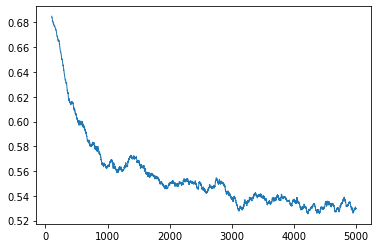

In [33]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [34]:
for p in model.parameters():
    p.requires_grad = True

In [35]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [36]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [37]:
full_steps = 95_000
batch_size = 4
report_steps = 100
train_max_length = 192  # 256 is preferable, but it OOMs often

In [38]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=full_steps)

In [120]:
model.train()
tq = trange(len(losses), head_steps + full_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/58628 [00:00<?, ?it/s]

41400 0.09553001534193754
41500 0.10744834769517184
41600 0.08931681904941798
41700 0.07785327054560184
41800 0.10507432989776135
41900 0.1316724342107773
42000 0.07045704655349255
42100 0.059239824712276457
42200 0.09062262330204249
42300 0.11276377607136964
42400 0.06039241656661034
42500 0.09326407067477703
42600 0.09800664685666562
42700 0.0599598366767168
42800 0.11673930004239082
42900 0.08467206865549087
43000 0.052435316145420074
43100 0.09603407561779022
43200 0.09403297908604145
43300 0.05953613478690386
43400 0.0715662020072341
43500 0.07742147076874971
43600 0.08967775844037533
43700 0.06874261025339365
43800 0.10682776041328906
43900 0.058923424780368806
44000 0.0755479308962822
44100 0.07128254301846028
44200 0.04368638943880796
44300 0.10651268534362317
44400 0.0827752586826682
44500 0.08825533617287874
44600 0.11473814029246569
44700 0.12270539302378893
44800 0.09063406769186258
44900 0.08696912586688996
45000 0.07086279232054948
45100 0.06446096882224082
45200 0.050868

73100 0.06428214456886053
73200 0.05309081044048071
73300 0.0715118495374918
73400 0.11089366197586059
73500 0.08396424002945423
73600 0.06613614659756423
73700 0.05730174589902162
73800 0.0628534683957696
73900 0.09278259959071875
74000 0.06416990250349044
74100 0.10057832024991513
74200 0.10406017404049635
74300 0.08763756014406682
74400 0.06256561990827322
74500 0.04455270573496819
74600 0.058178429380059245
74700 0.051317039020359514
74800 0.08998266786336899
74900 0.0749446377903223
75000 0.10063505079597235
75100 0.076199367120862
75200 0.04561294961720705
75300 0.060845303013920785
75400 0.08694456323981285
75500 0.10707788743078708
75600 0.08381411973387003
75700 0.10649745237082243
75800 0.06933095056563615
75900 0.0574299793690443
76000 0.10082930102944374
76100 0.05665803197771311
76200 0.0862145684286952
76300 0.06426511850208044
76400 0.051309041641652585
76500 0.06824078015983105
76600 0.03998968355357647
76700 0.08864893551915884
76800 0.06985587310045957
76900 0.0544077

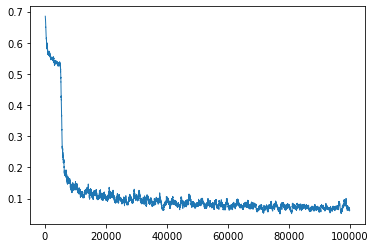

In [121]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

With label smoothing of 1%, the lower bound for the loss is about 6%, so the model has learned all it could.

In [122]:
p = 0.01
- (np.log(p) * p + np.log(1-p) * (1-p))

0.056001534354847345

In [123]:
loss = None
cleanup()
model.eval();

In [124]:
eval_bs = 8

In [125]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

  0%|          | 0/218 [00:00<?, ?it/s]

0.7449025481542462


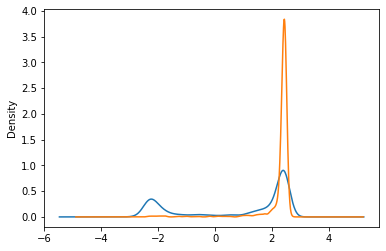

In [126]:
pd.Series(np.log10(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [127]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.9060711
0.9116465863453815


By filtering, we can easily filter out about 1/2 or 2/3 of bad pairs. 

However, the resulting bad pairs are really difficult to detect. 

In [128]:
threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

recall@ ideal reject rate: 0.5478036175710594 th: 0.994213390678629


In [129]:
data_val.is_correct.groupby(['accepted' if l > 0.1 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,275,1334
rejected,112,22


In [130]:
data_val.is_correct.groupby(['accepted' if l > 0.5 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,262,1327
rejected,125,29


In [131]:
data_val.is_correct.groupby(['accepted' if l > 0.9 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,249,1315
rejected,138,41


In [132]:
data_val.is_correct.groupby(['accepted' if l > 0.98 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,219,1281
rejected,168,75


In [133]:
model.save_pretrained('../models/bak-ru-cross-v2-easy-negatives');

# Harder (corrupted) negatives

In [382]:
# borrowed from https://github.com/natasha/naeval/tree/master/naeval/segment

import re
from collections import namedtuple


TOKEN = re.compile(r'([^\W\d]+|\d+|[^\w\s])')
WORD = re.compile('^[\w\d]+$')

Substring = namedtuple('Substring', ['start', 'end', 'text'])

def find_substrings(chunks, text):
    offset = 0
    for chunk in chunks:
        start = text.find(chunk, offset)
        stop = start + len(chunk)
        yield Substring(start, stop, chunk)
        offset = stop

def re_tokenize(text):
    chunks = TOKEN.findall(text)
    return find_substrings(chunks, text)

def is_word(text):
    return bool(re.match(WORD, text))

In [601]:
def insert_word(sent, word, position=None):
    """ Cleanly insert a word randomly into a sentence"""
    toks = list(re_tokenize(sent))
    # before which token we'll insert the word
    if position is None:
        position = random.randint(0, len(toks) if is_word(toks[-1].text) else len(toks)-1)
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        return word + ' ' + sent[0].lower() + sent[1:]
    if position == len(toks): # the last token is a word, so we just add one more
        return sent + ' ' + word
    next_tok = toks[position]
    if is_word(next_tok.text) or sent[next_tok.start-1] == ' ':
        word = word + ' '  # insert space between the added word and the next one
    else:
        word = ' ' + word
    return sent[:next_tok.start] + word + sent[next_tok.start:]

def remove_word(sent, position=None):
    """ Cleanly remove a word randomly from a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    
    if position == 0:
        res = sent[toks[1].start:]
        if sent[0].isupper():
            res = res[0].upper() + res[1:]
        return res
    if position == len(toks)-1:
        return sent[:toks[-2].end]
    tok = toks[position]
    spaces_around = (sent[tok.start-1] == ' ') + (sent[tok.end] == ' ')
    extra_space = ''
    if spaces_around == 2 or not is_word(tok.text) and spaces_around == 1:
        extra_space = ' '
    return sent[:toks[position-1].end] + extra_space + sent[toks[position+1].start:]


def replace_word(sent, word, position=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 1:
        return sent
    if position is None:
        position = random.randint(0, len(toks)-1)
    tok = toks[position]
    
    if position == 0:
        if sent[0].isupper():
            word = word[0].upper() + word[1:]
        res = word
    else:
        res = sent[:tok.start] + (' ' if sent[tok.start-1] != ' ' and not is_word(tok.text) else '') + word
    if position < len(toks) - 1:
        if sent[tok.end] != ' ' and not is_word(tok.text):
            res = res + ' '
        res = res + sent[tok.end:]
    return res


def swap_words(sent, position1=None, position2=None):
    """ Cleanly replace a word randomly in a sentence"""
    toks = list(re_tokenize(sent))
    if len(toks) < 2:
        return sent
    if position1 is None:
        position1 = random.randint(0, len(toks)-1)
    while position2 is None or position2 == position1:
        position2 = random.randint(0, len(toks)-1)
    w1, w2 = toks[position1].text, toks[position2].text
    
    sent = replace_word(sent, w2, position1)
    sent = replace_word(sent, w1, position2)
    return sent


def get_other_word(ix):
    sent = random.choice(all_pairs)[ix]
    return random.choice(list(re_tokenize(sent))).text


def corrupt_sentence(sent, ix, p_edit=0.5):
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent.split()) == 1:
            sent = insert_word(sent, get_other_word(ix))
        # replace a random word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = replace_word(sent, get_other_word(ix))
        # remove a word
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = remove_word(sent)
        # swap words
        if random.random() < p_edit and len(sent.split()) > 1:
            sent = swap_words(sent)
    return sent

def corrupt_pair(pair):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])
    sent = pair[ix]
    pair[ix] = corrupt_sentence(sent, ix)
    return pair

In [602]:
text = 'Казнить нельзя, помиловать (приказом короля) велено!'

In [603]:
for s in sorted({swap_words(text) for _ in range(200)}):
    print(s)

! нельзя, помиловать (приказом короля) велено Казнить
( нельзя, помиловать Казнить приказом короля) велено!
) нельзя, помиловать (приказом короля Казнить велено!
, нельзя Казнить помиловать (приказом короля) велено!
Велено нельзя, помиловать (приказом короля) Казнить!
Казнить !, помиловать (приказом короля) велено нельзя
Казнить (, помиловать нельзя приказом короля) велено!
Казнить ), помиловать (приказом короля нельзя велено!
Казнить , нельзя помиловать (приказом короля) велено!
Казнить велено, помиловать (приказом короля) нельзя!
Казнить короля, помиловать (приказом нельзя) велено!
Казнить нельзя ! помиловать (приказом короля) велено ,
Казнить нельзя ( помиловать , приказом короля) велено!
Казнить нельзя ) помиловать (приказом короля , велено!
Казнить нельзя велено помиловать (приказом короля) ,!
Казнить нельзя короля помиловать (приказом ,) велено!
Казнить нельзя помиловать , (приказом короля) велено!
Казнить нельзя приказом помиловать (, короля) велено!
Казнить нельзя, ! (приказом 

In [604]:
for s in sorted({replace_word(text, 'конь') for _ in range(200)}):
    print(s)

Казнить конь, помиловать (приказом короля) велено!
Казнить нельзя конь помиловать (приказом короля) велено!
Казнить нельзя, конь (приказом короля) велено!
Казнить нельзя, помиловать (конь короля) велено!
Казнить нельзя, помиловать (приказом конь) велено!
Казнить нельзя, помиловать (приказом короля конь велено!
Казнить нельзя, помиловать (приказом короля) велено конь
Казнить нельзя, помиловать (приказом короля) конь!
Казнить нельзя, помиловать конь приказом короля) велено!
Конь нельзя, помиловать (приказом короля) велено!


In [605]:
for s in sorted({insert_word('Казнить нельзя, помиловать (приказом короля) велено!', 'конь') for _ in range(200)}):
    print(s)

Казнить конь нельзя, помиловать (приказом короля) велено!
Казнить нельзя конь, помиловать (приказом короля) велено!
Казнить нельзя, конь помиловать (приказом короля) велено!
Казнить нельзя, помиловать (конь приказом короля) велено!
Казнить нельзя, помиловать (приказом конь короля) велено!
Казнить нельзя, помиловать (приказом короля конь) велено!
Казнить нельзя, помиловать (приказом короля) велено конь!
Казнить нельзя, помиловать (приказом короля) конь велено!
Казнить нельзя, помиловать конь (приказом короля) велено!
Конь казнить нельзя, помиловать (приказом короля) велено!


In [606]:
for s in sorted({remove_word('Казнить нельзя, помиловать (приказом короля) велено!') for _ in range(200)}):
    print(s)

Казнить нельзя помиловать (приказом короля) велено!
Казнить нельзя, (приказом короля) велено!
Казнить нельзя, помиловать (короля) велено!
Казнить нельзя, помиловать (приказом короля велено!
Казнить нельзя, помиловать (приказом короля) велено
Казнить нельзя, помиловать (приказом короля)!
Казнить нельзя, помиловать (приказом) велено!
Казнить нельзя, помиловать приказом короля) велено!
Казнить, помиловать (приказом короля) велено!
Нельзя, помиловать (приказом короля) велено!


In [607]:
list(re_tokenize('Казнить нельзя, помиловать (приказом короля) велено!'))

[Substring(start=0, end=7, text='Казнить'),
 Substring(start=8, end=14, text='нельзя'),
 Substring(start=14, end=15, text=','),
 Substring(start=16, end=26, text='помиловать'),
 Substring(start=27, end=28, text='('),
 Substring(start=28, end=36, text='приказом'),
 Substring(start=37, end=43, text='короля'),
 Substring(start=43, end=44, text=')'),
 Substring(start=45, end=51, text='велено'),
 Substring(start=51, end=52, text='!')]

In [611]:
pair = random.choice(all_pairs)
pair

('Тыштан түгел, эстән.', 'Не внешне – а изнутри, и я это почувствовала.')

In [612]:
corrupt_pair(pair)

['Түгел Ҡасыу, . эстән', 'Не внешне – а изнутри, и я это почувствовала.']

About 70% of corrupted pairs really change meaning, and about 50% of them are linguistically acceptable - which seems ok. 

In [613]:
for _ in range(10):
    print(corrupt_sentence(pair[1], 1))

Не внешне – а изнутри, и это вскочив почувствовала.
Внешне Беда а изнутри, . смешном я это почувствовала и
Не внешне – а хлеба, и я это почувствовала.
Не внешне – изнутри, и я это почувствовала.
Не внешне – я изнутри из и а это почувствовала.
Не внешне – а изнутри, и я почувствовала трактор возмещен
Не внешне – а изнутри, и целительских это почувствовала умолк
Не внешне а изнутри, и я — это почувствовала.
Не и махнув – а изнутри, внешне я это почувствовала.
Не уснуть внешне – а изнутри, и я это почувствовала.


In [614]:
def get_pairs_contrastive_batch(bs=4, p_difficult=0.5):
    assert bs >= 4
    batch = random.sample(all_pairs, bs // 2) # data_train_correct.sample(bs // 2)
    pp = batch # [[row.ba, row.ru] for row in batch.itertuples()]
    labels = [1 for row in pp]
    if random.random() < p_difficult:
        for i in range(len(pp)):
            pp.append(corrupt_pair(pp[i]))
            labels.append(0)
    else:
        for i in range(len(pp)):
            pp.append([pp[i][0], pp[i-1][1]])
            labels.append(0)
    return [list(t) for t in zip(*pp)], labels

In [627]:
get_pairs_contrastive_batch()

([['Ул хаттарҙы уҡырға тотондо. Тик күҙ йәштәре ирек бирмәне.',
   'Хәйер, уны һин үҙең дә күрһәтмәйәсәкһең.',
   'Ул хаттарҙы уҡырға тотондо. Тик күҙ Хирург ирек бирмәне.',
   'Хәйер, уны һин үҙең дә күрһәтмәйәсәкһең.'],
  ['Он начал читать письма и не мог удержаться от слёз.',
   'Впрочем, ты и сам не захочешь их показывать.',
   'Он начал читать письма и не мог удержаться от слёз.',
   'Впрочем не ты и сам живом захочешь их показывать.']],
 [1, 1, 0, 0])

## Train with these harder examples

In [628]:
model, loss, optimizer = None, None, None
cleanup()

In [629]:
model = AutoModelForSequenceClassification.from_pretrained(base_model).cuda();

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [630]:
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [631]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [632]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-4, clip_threshold=1.0
)
cleanup()

In [633]:
losses = []

In [634]:
head_steps = 5_000
batch_size = 8
report_steps = 100
train_max_length = 256

In [635]:
loss_fn = torch.nn.CrossEntropyLoss()

In [636]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=head_steps)

In [637]:
model.train()
tq = trange(len(losses), head_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/5000 [00:00<?, ?it/s]

0 0.7091808319091797
100 0.7021327739953995
200 0.6849219721555709
300 0.6725764143466949
400 0.6592385965585709
500 0.6434589621424674
600 0.623248008787632
700 0.6458574113249779
800 0.6473178082704544
900 0.6262586438655853
1000 0.6268628087639808
1100 0.6426221686601639
1200 0.6465109494328499
1300 0.6250256243348121
1400 0.6447769677639008
1500 0.6451832228899002
1600 0.6325877153873444
1700 0.644515183866024
1800 0.640305661559105
1900 0.6440346348285675
2000 0.6438755810260772
2100 0.6291194620728493
2200 0.644684390425682
2300 0.6247145554423332
2400 0.6364124503731727
2500 0.6286642336845398
2600 0.653277980685234
2700 0.6209691914916039
2800 0.6362006822228432
2900 0.6265427914261817
3000 0.6358052560687065
3100 0.6366638672351838
3200 0.6453710851073265
3300 0.6271569925546646
3400 0.6356926229596138
3500 0.6382840302586555
3600 0.6385248905420303
3700 0.6345472824573517
3800 0.6420348355174065
3900 0.6378945446014405
4000 0.6298359534144402
4100 0.6475587889552117
4200 0.63

With harder negatives, the loss is higher than with random ones. 

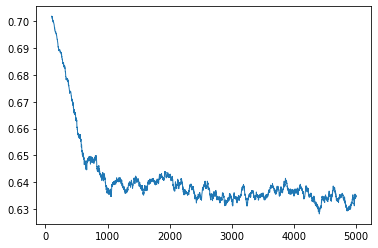

In [638]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

In [639]:
for p in model.parameters():
    p.requires_grad = True

In [640]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, relative_step=False, lr=1e-5, clip_threshold=1.0
)

In [641]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.01)

In [642]:
full_steps = 95_000
batch_size = 4
report_steps = 100
train_max_length = 192  # 256 is preferable, but it OOMs often

In [643]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1000, num_training_steps=full_steps)

In [680]:
model.train()
tq = trange(len(losses), head_steps + full_steps)
for i in tq:
    pp, pl = get_pairs_contrastive_batch(bs=batch_size)
    try:
        loss = loss_fn(
            model(
                **tokenizer(*pp, padding=True, truncation=True, max_length=train_max_length, return_tensors='pt').to(model.device)
            ).logits.view(-1, 2),
            torch.tensor(pl, device=model.device)
        )
        loss.backward()
        losses.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        batch, out, embeddings, all_scores, loss = None, None, None, None, None
        cleanup()
        print('error', max(len(s) for s in pp[0]+pp[1]))
        continue
    if i % report_steps == 0:
        print(i, np.mean(losses[-report_steps:]))

  0%|          | 0/30409 [00:00<?, ?it/s]

69600 0.24202276177704335
69700 0.22392261754721404
69800 0.22490376241505147
69900 0.22546011064201593
70000 0.18536391008645295
70100 0.247642133384943
70200 0.20646942660212517
70300 0.23032736830413342
70400 0.23659201182425021
70500 0.25454128444194796
70600 0.2752047723531723
70700 0.19343646798282862
70800 0.23389870390295983
70900 0.29898697420954706
71000 0.2653034630790353
71100 0.2571105074137449
71200 0.22587883070111275
71300 0.2909691197052598
71400 0.22461317840963602
71500 0.2774054127559066
71600 0.2522082997858524
71700 0.26570322580635547
71800 0.2284913221374154
71900 0.23876978293061257
72000 0.23269013326615096
72100 0.24505342643707992
72200 0.26695590499788524
72300 0.27364269334822894
72400 0.2628078476712108
72500 0.2683627378568053
72600 0.23241187393665313
72700 0.18743824746459722
72800 0.2544081100076437
72900 0.25661327261477707
73000 0.1982424844801426
73100 0.21870930425822735
73200 0.1790608250722289
73300 0.2334171437844634
73400 0.2116136836260557
73

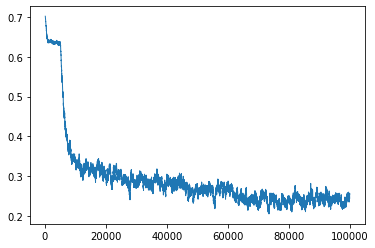

In [681]:
pd.Series(losses).ewm(300).mean()[100:].plot(lw=1);

???

In [682]:
loss = None
cleanup()
model.eval();

In [683]:
!nvidia-smi

Sun Mar 05 00:31:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   77C    P0    26W /  N/A |   1917MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [684]:
eval_bs = 8

In [685]:
logits = []
for i in trange(0, data_val.shape[0], eval_bs):
    batch = data_val.iloc[i:i+eval_bs]
    with torch.inference_mode():
        logits.extend(torch.softmax(model(
            **tokenizer(batch.ba.tolist(), batch.ru.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt').to(model.device)
        ).logits.view(-1, 2), -1)[:, 1].cpu().numpy())
        
logits = np.array(logits)
print(roc_auc_score(data_val.is_correct, logits))

  0%|          | 0/218 [00:00<?, ?it/s]

0.7797996082108039


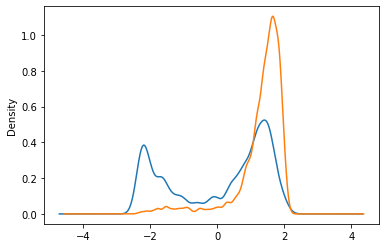

In [686]:
pd.Series(np.log10(logits / (1-logits)), index=data_val.index).groupby(data_val.is_correct).plot(
    kind='kde', bw_method=0.1,
);

In [687]:
print(data_val.is_correct.mean())
print(logits.mean())
print((logits>0.5).mean())

0.7779690189328744
0.82643497
0.8623063683304647


???

In [688]:
threshold = np.quantile(logits, 1-data_val.is_correct.mean())
print('recall@ ideal reject rate:', (logits < threshold)[data_val.is_correct.values==0].mean(), 'th:', threshold)

recall@ ideal reject rate: 0.5452196382428941 th: 0.8679616847259862


In [689]:
data_val.is_correct.groupby(['accepted' if l > 0.1 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,257,1307
rejected,130,49


In [690]:
data_val.is_correct.groupby(['accepted' if l > 0.5 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,231,1272
rejected,156,84


In [691]:
data_val.is_correct.groupby(['accepted' if l > 0.9 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,163,1129
rejected,224,227


In [692]:
data_val.is_correct.groupby(['accepted' if l > 0.98 else 'rejected' for l in logits]).value_counts().unstack()

is_correct,0,1
accepted,25,405
rejected,362,951


In [693]:
model.save_pretrained('../models/bak-ru-cross-v3-hard-negatives');